<a href="https://colab.research.google.com/github/ftxsilva/PIE-33/blob/master/Analyse_de_Cause_Racine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Étude de Cause Racine

Dans ce notebook nous allons étudier des causes racines des problèmes de non-qualité à partir des méthodes suivantes:


*   Random Forest 
*   XGBoost
*   Artificial Neural Network
*   Étude de causalité
*   Permutation importance


## Importer des libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import io
import collections
from sklearn.model_selection import train_test_split
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,\
    roc_curve, auc, confusion_matrix, precision_recall_curve



import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras import layers
from keras.models import Model
from keras import backend as K
from keras.utils import plot_model
from tensorflow import keras

from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


     |████████████████████████████████| 112kB 3.3MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Lire le jeu de donner "Clean"

In [ ]:
dataframe = pd.read_csv('Data_traite_decembreV7.csv' , sep=',',decimal=b'.')
dataframe.shape

(1559, 62)


### Separation de variables en categories

In [ ]:
for name in dataframe.columns:
    l = np.array(dataframe[name])
    if len(collections.Counter(l)) == 1:
        dataframe.drop(name,1, inplace = True)

print('Unique types of variables: ', dataframe.dtypes.unique())
floats = dataframe.select_dtypes('float64')
categories = dataframe.select_dtypes('O')
ints = dataframe.select_dtypes('int64')

len(categories.columns) + len(floats.columns) == len(dataframe.columns)
print('# of columns: ', len(dataframe.columns))
print('# of Categorical columns: ', len(categories.columns))
print('# of Float columns: ', len(floats.columns))
print('# of Int columns: ', len(ints.columns))

Unique types of variables:  [dtype('float64') dtype('int64')]
# of columns:  62
# of Categorical columns:  0
# of Float columns:  39
# of Int columns:  23


### Training-Test Split et Classification des données

In [ ]:
'''
    Training data
'''
# Selecting float dataset
df = floats.iloc[:,:-1]
vec = floats.iloc[:,-1].values
defect = vec > 20
df_defect = pd.DataFrame(defect, columns=['Classification']).astype('uint8')

df = df.iloc[:,:-1]

# Normalizing
x = df
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

X = x_scaled
y = df_defect.to_numpy()
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)

## Constructions des modèles de classification


### 1. Random Forest

In [ ]:
rfc = RandomForestClassifier(n_estimators=10, criterion='entropy')
rfc.fit(train_X,train_y)

print("Learning score: %g"%(rfc.score(train_X,train_y)))
print("Generalization score: %g"%(rfc.score(val_X,val_y)))

Learning score: 0.99059
Generalization score: 0.915385


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [ ]:
# Model Evaluation metrics 
y_pred = rfc.predict(val_X)
print('Accuracy Score : ' + str(accuracy_score(val_y,y_pred)))
print('Precision Score : ' + str(precision_score(val_y, y_pred)))
print('Recall Score : ' + str(recall_score(val_y, y_pred)))
print('F1 Score : ' + str(f1_score(val_y, y_pred)))
print('Confusion Matrix : \n' + str(confusion_matrix(val_y, y_pred)))

Accuracy Score : 0.9153846153846154
Precision Score : 0.5909090909090909
Recall Score : 0.35135135135135137
F1 Score : 0.4406779661016949
Confusion Matrix : 
[[344   9]
 [ 24  13]]


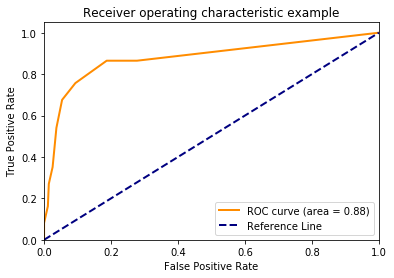

In [ ]:
# Compute ROC curve and ROC area for each class

fpr, tpr, thresholds = roc_curve(y_true = val_y, y_score = rfc.predict_proba(val_X)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label = 'Reference Line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

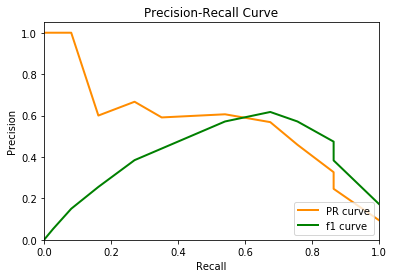

In [ ]:
precision, recall, thresholds = precision_recall_curve(val_y, rfc.predict_proba(val_X)[:,1])

plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange', lw=lw, label='PR curve')
plt.plot(recall, 2*recall*precision/(recall+precision), color='green', lw=lw, label='f1 curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
bestf1 = max(2*recall*precision/(recall+precision))
print("The best f1 score found is: %0.2f" %bestf1)

The best f1 score found is: 0.62


### 2. XGBoost

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(x, y)

i = 0
dict1 = {}
for col in train_X.columns:
    dict1[col] = i
    i+=1

train_X1 = train_X.rename(columns = dict1, inplace = False)
val_X1 = val_X.rename(columns = dict1, inplace = False)

xgbC = XGBClassifier(n_estimators=200)
xgbC.fit(train_X1,train_y.reshape(1,-1)[0])
preds = xgbC.predict(val_X1)
acc_xgb = (preds == val_y.reshape(1,-1)[0]).sum().astype(float) / len(preds)*100
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))

XGBoost's prediction accuracy is: 91.28


In [ ]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(val_y,preds)))
print('Precision Score : ' + str(precision_score(val_y, preds)))
print('Recall Score : ' + str(recall_score(val_y, preds)))
print('F1 Score : ' + str(f1_score(val_y, preds)))

print('Confusion Matrix : \n' + str(confusion_matrix(val_y, preds)))

Accuracy Score : 0.9128205128205128
Precision Score : 0.625
Recall Score : 0.2631578947368421
F1 Score : 0.37037037037037035
Confusion Matrix : 
[[346   6]
 [ 28  10]]


### 3. Artificial Neural Network

In [ ]:
'''
    Fixed parameters
'''
n_features = np.size(X,1)

'''
    Parameters possibilities
'''
layerWidth = [64, 64, 1]
activationFunctions = ['linear','sigmoid', 'relu', 'softmax']
lossFunctions = ['mean_squared_error', 'categorical_crossentropy', 'binary_crossentropy']
optimzerOptions = ['adam', 'sgd']
batchSizes = [256]
callbacks_list = []
allNumEpochs = [1000]

'''
    Chosen parameters
'''
lossFunc = lossFunctions[0]
optimizer = optimzerOptions[1]
batchSize = batchSizes[0]
numEpochs = allNumEpochs[0]

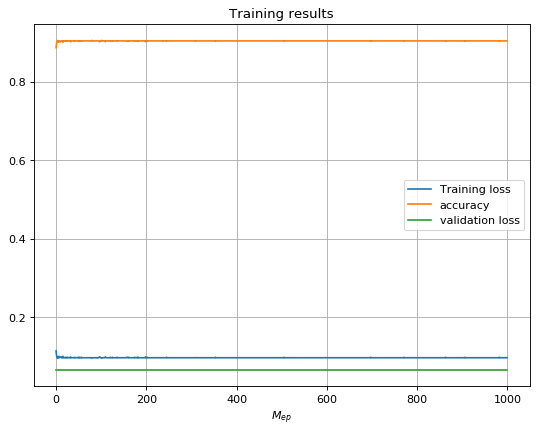

Final training loss: 0.09589041102694594
Final validation loss: 0.06484641654753848


In [ ]:
'''
    Architecture
'''
def round_func(x):
    return K.round(x)

def base_model():
    model =  tf.keras.Sequential([
        layers.Dense(layerWidth[0], activation=activationFunctions[2], input_shape=(n_features,), name='Input'),
        layers.Dropout(0.1),
        layers.Dense(layerWidth[0], activation=activationFunctions[2], input_shape=(n_features,), name='HL1'),
        layers.Dropout(0.1),
        layers.Dense(layerWidth[2], activation=activationFunctions[1], name='Output'),
    ], name='Sequential_NN')
    model.compile(loss=lossFunc, optimizer=optimizer, metrics=['accuracy'])
    return model
'''
    Overall Settings/ Compilation
'''
ANN = base_model()

''' 
    Training
'''
history = ANN.fit(train_X, train_y, validation_split=0.25, epochs=numEpochs, 
                  batch_size=batchSize, shuffle=True, verbose=0, 
                  callbacks=callbacks_list)
'''
    Plotting
'''

trainingFig = plt.figure(figsize=(8, 6), dpi=80)
plt.title('Training results')
plt.plot(history.history['loss']) # all outputs: ['acc', 'loss', 'val_acc', 'val_loss']
plt.plot(history.history['acc'])
plt.grid(True, which='both')
plt.plot(history.history['val_loss'])
plt.xlabel('$M_{ep}$')
plt.legend(['Training loss', 'accuracy', 'validation loss'])
plt.show()

print('Final training loss:', history.history['loss'][-1])
print('Final validation loss:', history.history['val_loss'][-1])

In [ ]:
'''
    Prediction
'''
pred = (ANN.predict(val_X)).reshape(-1) > 0.5
val = (np.round(ANN.predict(val_X)) == val_y.reshape(-1))

print("Validation score", np.sum(val)/len(val))

Validation score 352.0


In [ ]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(val_y,pred)))
print('Precision Score : ' + str(precision_score(val_y, pred)))
print('Recall Score : ' + str(recall_score(val_y, pred)))
print('F1 Score : ' + str(f1_score(val_y, pred)))

from sklearn.metrics import confusion_matrix
print('Confusion Matrix : \n' + str(confusion_matrix(val_y, pred)))

Accuracy Score : 0.9025641025641026
Precision Score : 0.0
Recall Score : 0.0
F1 Score : 0.0
Confusion Matrix : 
[[352   0]
 [ 38   0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Étude de causalité

### - Random Forest

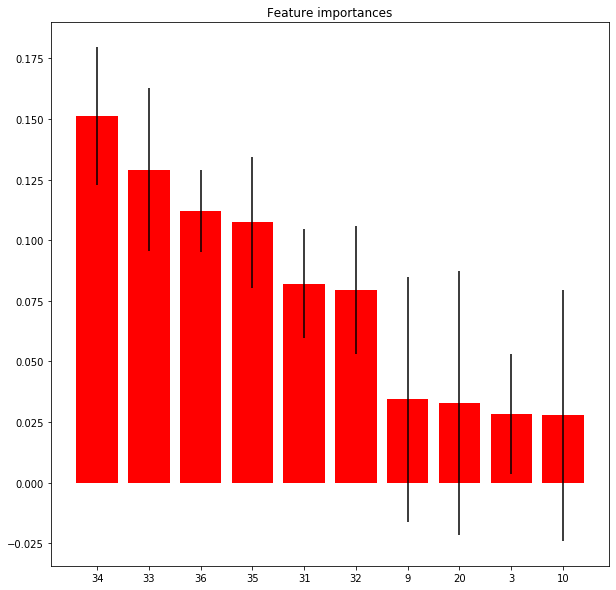

In [ ]:
# Feature importance
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
ordered_importance = [importances[i] for i in indices]

plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(10),importances[indices[0:10]], color="r", yerr=std[indices[0:10]], align="center")
plt.xticks(range(10), indices[0:10])
plt.show()

In [ ]:
print(x.columns[31])
print(x.columns[32])
print(x.columns[6])
print(x.columns[3])
print(x.columns[8])

E45E35E36 P < 6.6 10-5mbar 1
E45E35E36 P < 6.6 10-5mbar 2
E24E25E37 IntercalaireFroid hauteur apres calibrage gauche
E24E25E37 IntercalaireFroid hauteur apres calibrage droit
E24E25E37 IntercalaireFroid hauteur apres calibrage milieu


### XGBoost


In [ ]:
importances = pd.DataFrame({
    'Feature': x.columns,
    'Importance': xgbC.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
#regarder les 5 plus importants features
importances[:5]

,Importance
Feature,
E24E25E37 IntercalaireFroid hauteur apres calibrage droit,0.156773
E24E25E37 IntercalaireFroid largeur de bande,0.080249
E24E25E37 IntercalaireFroid hauteur apres calibrage milieu,0.054575
E24E25E37 IntercalaireFroid hauteur sorti formage milieu Max,0.051669
E24E25E37 IntercalaireFroid Longueur Mesuree LM/100plis Max,0.040995


## Permutation importance

### - Random Forest

In [ ]:
#prefit parce que le modele est deja fitte, on veut seulement faire le random shuffle avec les donnes de test
perm = PermutationImportance(rfc, random_state=1, n_iter = 10, cv='prefit').fit(val_X, val_y)
eli5.show_weights(perm, feature_names = x.columns.tolist())

/usr/local/lib/python3.6/dist-packages/eli5/formatters/html.py:235: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,E24E25E37 IntercalaireFroid largeur de bande
0 ± 0.0000,E24E25E37 IntercalaireFroid hauteur apres calibrage droit
0 ± 0.0000,E24E25E37 IntercalaireFroid hauteur apres calibrage droit Max
0 ± 0.0000,E24E25E37 IntercalaireFroid hauteur apres calibrage droit Min
0 ± 0.0000,E24E25E37 IntercalaireFroid hauteur apres calibrage gauche
0 ± 0.0000,E24E25E37 IntercalaireFroid hauteur apres calibrage gauche Min
0 ± 0.0000,E24E25E37 IntercalaireFroid hauteur apres calibrage milieu
0 ± 0.0000,E24E25E37 IntercalaireFroid hauteur apres calibrage milieu Max
0 ± 0.0000,E24E25E37 IntercalaireFroid hauteur apres calibrage milieu Min
0 ± 0.0000,E24E25E37 IntercalaireFroid hauteur sorti formage droit


### - Aritificial Neural Network

In [ ]:
perm = PermutationImportance(ANN, cv='prefit', n_iter=2).fit(val_X, val_y, verbose=0)
eli5.show_weights(perm, feature_names = x.columns.tolist())

390/390 [==============================] - 0s 36us/sample - loss: 0.3279 - acc: 0.9051


Weight,Feature
0.0019 ± 0.0005,E24E25E37 IntercalaireFroid largeur de passe (longueur)
0.0013 ± 0.0001,E24E25E37 IntercalaireFroid largeur de bande Max
0.0007 ± 0.0003,E24E25E37 IntercalaireFroid Longueur Mesuree LM/100plis
0.0004 ± 0.0000,E24E25E37 IntercalaireFroid largeur de bande Min
0.0004 ± 0.0101,E49 Perpendicularité passe chaude
0.0003 ± 0.0001,E24E25E37 IntercalaireFroid largeur de passe (longueur) Min
0.0003 ± 0.0004,E24E25E37 IntercalaireFroid Longueur Mesuree LM/100plis Max
0.0002 ± 0.0001,E24E25E37 IntercalaireFroid pic et creux local dessus Max
0.0002 ± 0.0001,E24E25E37 IntercalaireFroid largeur de bande
0.0001 ± 0.0001,E24E25E37 IntercalaireFroid pic et creux local dessous Max


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
dfy = pd.DataFrame(data = y
             , columns = ['Class'])
principalDf.head(1)

,principal component 1,principal component 2
0,-0.12142,0.115413


In [ ]:
finalDf = pd.concat([principalDf, dfy], axis = 1)
finalDf.head(1)

,principal component 1,principal component 2,Class
0,-0.12142,0.115413,0


In [ ]:
def get_z(rfc):
    z = []
    for pred, label in zip(rfc.predict(X), y.reshape(-1)):
        if np.int(pred) == np.int(label):
            z.append(1)
        elif (np.int(pred) - np.int(label)) == -1:
            z.append(2)
        else:
            z.append(3)
    return np.array(z)

In [ ]:
z = get_z(rfc)

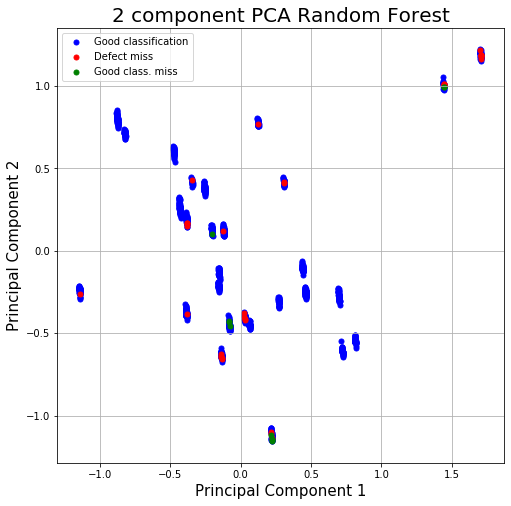

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA Random Forest', fontsize = 20)
targets = [1, 2, 3]
colors = ['b', 'r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = z == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 25)
ax.legend(['Good classification', 'Defect miss', 'Good class. miss'])
ax.grid()

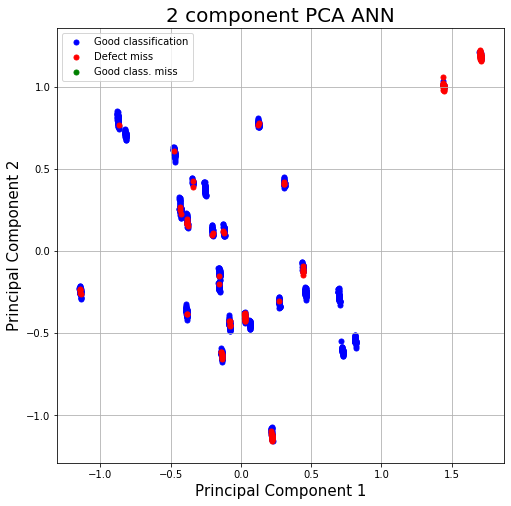

In [ ]:
z = get_z(ANN)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA ANN', fontsize = 20)
targets = [1, 2, 3]
colors = ['b', 'r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = z == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 25)
ax.legend(['Good classification', 'Defect miss', 'Good class. miss'])
ax.grid()

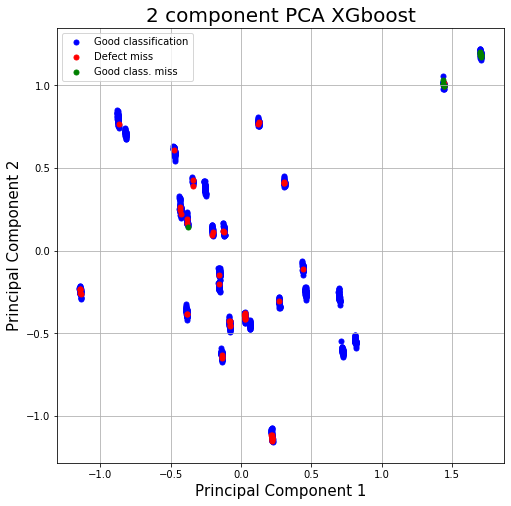

In [ ]:
i = 0
dict1 = {}
for col in df.columns:
    dict1[col] = i
    i+=1

X1 = df.rename(columns = dict1, inplace = False)
X1 = df.rename(columns = dict1, inplace = False)

xgbC = XGBClassifier(n_estimators=200)
xgbC.fit(X1,y.reshape(1,-1)[0])
preds = xgbC.predict(X1)
z = []
for pred, label in zip(preds, y.reshape(-1)):
    if np.int(pred) == np.int(label):
        z.append(1)
    elif (np.int(pred) - np.int(label)) == -1:
        z.append(2)
    else:
        z.append(3)
z = np.array(z)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA XGboost', fontsize = 20)
targets = [1, 2, 3]
colors = ['b', 'r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = z == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 25)
ax.legend(['Good classification', 'Defect miss', 'Good class. miss'])
ax.grid()